In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [17]:
img = cv2.imread('lena.jpg')
h = img.shape[0]
w = img.shape[1]

### 基本思想
假设在每个区域**最小值的位置**上打一个洞并且让水以均匀的上升速率从洞中涌出，从低到高淹没整个地形。当处在不同的汇聚盆地中的水将要聚合在一起时，修建的大坝将阻止聚合。这些大坝的边界对应于**分水岭的分割线**。所以，它们是由分水岭算法提取出来的(连续的)边界线。

在真实图像中，由于噪声点或者其它干扰因素的存在，使用分水岭算法常常存在过度分割的现象。

为了解决过度分割的问题，可以使用基于标记(mark)图像的分水岭算法。

通常的mark图像，都是在某个区域**定义一些灰度层级**，在这个区域的洪水淹没过程中，水平面都是**从定义的高度开始**的，这样可以避免一些很小的噪声极值区域的分割。

In [18]:
def Watershed(img):
    Img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(Img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # 对图像进行“开运算”，先腐蚀再膨胀
    kernel = np.ones((3, 3), dtype=np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)
    
    #对“开运算”的结果进行膨胀，得到大部分都是背景的区域
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    #通过distanceTransform获取前景区域
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)

    #sure_bg与sure_fg相减,得到既有前景又有背景的重合区域   
    sure_fg = np.uint8(sure_fg)
    unknow = cv2.subtract(sure_bg, sure_fg)#此区域和轮廓区域的关系未知

    #连通区域处理
    ret, markers = cv2.connectedComponents(sure_fg,connectivity=8) #对连通区域进行标号  序号为 0 - N-1 
    markers = markers + 1#OpenCV 分水岭算法对物体做的标注必须都 大于1 ，背景为标号 为0  因此对所有markers 加1  变成了  1  -  N
    #去掉属于背景区域的部分（即让其变为0，成为背景）
    # 此语句的Python语法 类似于if ，“unknow==255” 返回的是图像矩阵的真值表。
    markers[unknow==255] = 0   

    #分水岭
    markers = cv2.watershed(img, markers)  #分水岭算法后，所有轮廓的像素点被标注为  -1 
    print(markers)
    img[markers == -1] = [0, 0, 255]   # 标注为-1 的像素点标 红

    return img


[[-1 -1 -1 ... -1 -1 -1]
 [-1  1  1 ...  1  1 -1]
 [-1  1  1 ...  1  1 -1]
 ...
 [-1 47 47 ... 45 45 -1]
 [-1 47 47 ... 45 45 -1]
 [-1 -1 -1 ... -1 -1 -1]]


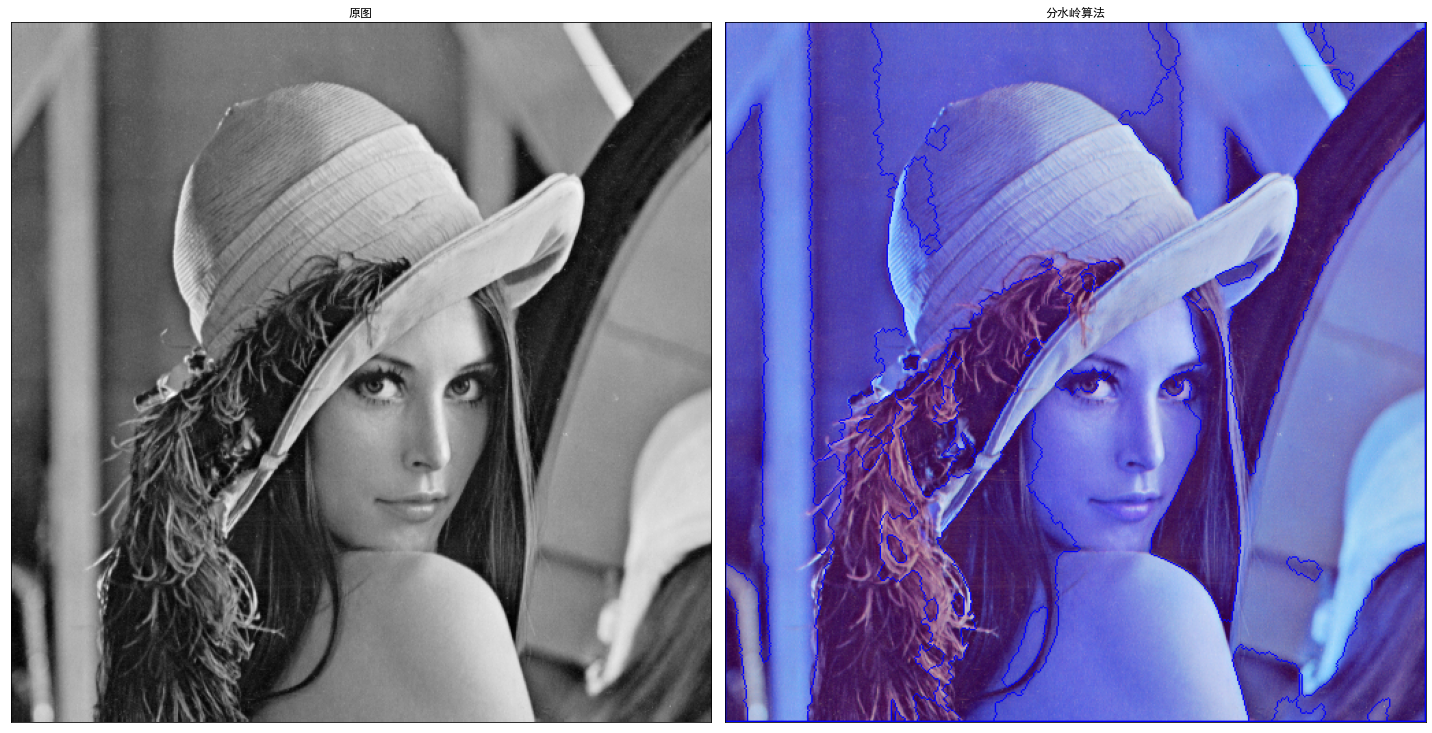

(None, None)

In [19]:
result = Watershed(img)

plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(Img, 'gray'), plt.title('原图'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(result, 'gray'), plt.title('分水岭算法'), plt.xticks([]), plt.yticks([])
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.tight_layout(), plt.show()